In [218]:

#!pip install --pre pycaret
#!pip install pycaret


In [219]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
import pandas as pd
import io
import numpy as np
import os

from datetime import datetime
#from download import download

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from google.colab import files
import time
import numpy as np
import pandas as pd
#import numpy as np
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from statsmodels.tsa.stattools import kpss
mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

In [220]:
#NECESSARY IMPORTS
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.api import VAR, adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop
from tensorflow.keras import Sequential, Model
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError , MeanAbsoluteError
from keras.layers import UpSampling1D,Input, Dense, SimpleRNN , Dropout,DepthwiseConv1D,Reshape, Attention, SpatialDropout1D,LSTM,LocallyConnected1D, GlobalMaxPooling1D,AveragePooling1D, Bidirectional, TimeDistributed, GRU, LayerNormalization, ConvLSTM1D
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.layers import Flatten, ConvLSTM2D
from keras.regularizers import l1, l2
from keras.layers import RepeatVector
import time
import random
#!pip install pandasql
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)
#import pandasql as ps
import matplotlib as mpl
import matplotlib.pyplot as plt
#from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) 
from sklearn.metrics import mean_squared_error

In [221]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [222]:
##########################################################
################ Data Preprocessing ######################
##########################################################

# Below function deals with converting the data into time series data with specific number of lags/window/timesteps

def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

# Below class deals with the Z-score Normalization / Splitting of the DataSet
# Here Ratio of Test , Train and Split is 81:9:10
# It can be reset using changing the split variable in __init__ function

class Standardize:
  def __init__(self, df, split=0.20):
    self.data=df
    self.split=split
  def split_data(self):
    n=int(len(self.data)*self.split)
    train, test=self.data.iloc[:-n], self.data.iloc[-n:]
    n=int(len(train)*self.split)
    train, val=train.iloc[:-n], train.iloc[-n:]
    assert len(test)+len(train)+len(val)==len(self.data)
    return train, test, val
    '''
  def split_data_view(self):
    n=int(len(self.data)*self.split)
    train, test=self.data.iloc[:-n], self.data.iloc[-n:]
    n=int(len(train)*self.split)
    train, val=train.iloc[:-n], train.iloc[-n:]
    assert len(test)+len(train)+len(val)==len(self.data)
    return train, val
    '''
  def transform(self, data):
    data_s=(data-self.mu)/self.sigma
    return data_s
  def fit_transform(self):
    train, test, val=self.split_data()
    self.mu, self.sigma= train.mean(),train.std()
    train_s=self.transform(train)
    test_s=self.transform(test)
    val_s=self.transform(val)
    return train_s, test_s, val_s
    '''
  def fit_transform_view(self):
    train, test, val=self.split_data_view()
    self.mu, self.sigma= train.mean(),train.std()
    train_s=self.transform(train)
    test_s=self.transform(test)
    val_s=self.transform(val)
    return train_s, test_s, val_s
    '''
  def inverse(self, data):
    return (data*self.sigma)+self.mu
  def inverse_y(self, data):
    return (data*self.sigma[-1])+self.mu[-1]


# This function deals with getting out the X and Y out of the dataset
# Column earlier named as 'y' will be taken out for processing, rest will be kept as x

def features_target_ts(*args):
        y=[col.pop('y').values.reshape(-1,1) for col in args]
        #yk=[col.pop('var5(t)').values.reshape(-1,1) for col in args]
        x=[col.values.reshape(*col.shape,1) for col in args]
        return *y, *x



#####################################################
################# Model Creation ####################
#####################################################
def create_model(train, units, dropout=0.2):
        # Variable-length int sequences.

        
        model_LSTM = Sequential()  
        model_LSTM.add(LSTM(256,activation='relu',input_shape=(train.shape[1], train.shape[2])))
        model_LSTM.add(Dense(1))
        model_LSTM._name='LSTM'
                  
        model_GRU = Sequential()  
        model_GRU.add(GRU(256,activation='relu',input_shape=(train.shape[1], train.shape[2])))
        model_GRU.add(Dense(1))
        model_GRU._name='GRU'
                      
        model_RNN = Sequential()  
        model_RNN.add(SimpleRNN(256,activation='relu',input_shape=(train.shape[1], train.shape[2])))
        model_RNN.add(Dense(1))
        model_RNN._name='RNN'
                      
        model_BiLSTM = Sequential()  
        #model_BiLSTM.add(Bidirectional(LSTM(256,activation='relu',input_shape=(train.shape[1], train.shape[2]))))
        model_BiLSTM.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(train.shape[1], train.shape[2])))
        #print(model_BiLSTM.output_shape)
        model_BiLSTM.add(Flatten())
        #print(model_BiLSTM.output_shape)
        model_BiLSTM.add(Dense(1))
        #print(model_BiLSTM.output_shape)
        model_BiLSTM._name='BiLSTM'
        #model_BiLSTM.add(Dense(1))
                  
        model_CNN = Sequential()  
        model_CNN.add(Conv1D(filters=256, kernel_size=1,input_shape=(train.shape[1], train.shape[2])))
        model_CNN.add(Flatten())
        model_CNN.add(Dense(1))
        model_CNN._name='CNN'
        return  model_LSTM, model_GRU, model_CNN, model_RNN, model_BiLSTM

# This function is responsible for model compilation and training 
def train_model_ts(model, x_train, y_train, x_val, y_val, epochs=250, patience =15, batch_size=66):
          model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
          es=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=patience)
          history=model.fit(x_train, y_train, shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val),callbacks=[es],verbose=1)
          return history

# This function is responsible for Loss and Validation Loss Graph along with Test Prediction
def plot_forecast(model, x_test, y_test, index, history):
          #fig, ax=plt.subplots(2,1)
          #(pd.Series(history.history['loss']).plot(style='k', alpha=0.50, title='Loss By Epoch',ax=ax[0], label='loss'))
          #(pd.Series(history.history['val_loss']).plot(style='k', alpha=0.50, title='Loss By Epoch',ax=ax[0], label='val_loss'))
          #ax[0].legend()
          predicted=model.predict(x_test)
          #pd.Series(y_test.reshape(-1), index=index).plot(style='k--', alpha=0.5, ax=ax[1], title='Forecast Vs Actual', label='actual')
          #pd.Series(predicted.reshape(-1), index=index).plot(style='k', ax=ax[1],  label='Forecast')
          #fig.tight_layout()
          #ax[1].legend()
          #plt.show()
          return predicted

def Measures(y_true,y_pred):
  '''All input in this function must be 'list' data structure'''

  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_percentage_error
  from sklearn.metrics import mean_absolute_error
  import math

  a=np.array(y_true)
  b=np.array(y_pred)
  rmse=math.sqrt(sum(pow(a-b,2))/len(a))
  mape=sum(abs((a-b)/b))/len(a)*100

  #print('rmse:',rmse)
  #print('mape:',mape)
  return([rmse,mape])

def DataTrainTestVal(df_new):   
    en_df=one_step_forecast(df_new, 12)
    #en_df

    # Object of Standardize class has been created with dataset as the parameter
    scale_en=Standardize(en_df)
    train_en, test_en, val_en=scale_en.fit_transform()
    
    # Spliting into test, train and validation set
    y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en= features_target_ts(train_en, val_en, test_en)
    return (y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en, test_en, scale_en, en_df, val_en, train_en) 



In [223]:
df= pd.read_csv('/content/drive/MyDrive/AI LAB CoLab/GradientBias time series analysis/Time Series Dataset/TS_datasets_processed/SunSpotMonthly_Data.csv')
#df_new.columns = ['y']
#df_new['y']
df.head()

,SunSpot
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


In [224]:

fh = 50 # or alternately fh = np.arange(1,13)
fold = 5

fig_kwargs={'renderer': 'notebook'}
eda = TSForecastingExperiment()

dd=eda.setup(data=df, fh=fh, fig_kwargs=fig_kwargs)

k=pd.DataFrame(dd.significant_sps)

seasonality=k.to_numpy().flatten()
seasonality_min=np.amin(seasonality)
print("Min seasonality_min:", seasonality_min)

,Description,Value
0,session_id,8887
1,Target,SunSpot
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(2820, 1)"
5,Transformed data shape,"(2820, 1)"
6,Transformed train set shape,"(2770, 1)"
7,Transformed test set shape,"(50, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Min seasonality_min: 9


In [225]:
data_array=df.to_numpy()
data_length=len(data_array)
Train_Data_Len=data_length*0.8
# Number of the views of the dataset....
view_max=2

Train_Data_Len
Views=[]
seasonal=[seasonality_min]

multiply=round((Train_Data_Len/view_max)/seasonality_min)

ViewsDataset=[]

seasonal=[seasonality_min]
for i in seasonal:
  print("Provided the Multiplication Factor: "+str(multiply)+" possible number of views is :"+str(round((Train_Data_Len/multiply)/i))+" for seasonality: "+str(i))
  Views.append(round((Train_Data_Len/multiply)/i))


Provided the Multiplication Factor: 125 possible number of views is :2 for seasonality: 9


In [226]:
Views

[2]

In [227]:
for j in seasonal:
  print(len(data_array[-(j*multiply):-1].tolist()))
  ViewsDataset.append(data_array[-(j*multiply):-1].tolist())
  for i in range(1,view_max):
    print(len(data_array[-(j*multiply)*(i+1):-(j*multiply)*(i)].tolist()))
    ViewsDataset.append(data_array[-(j*multiply)*(i+1):-(j*multiply)*(i)].tolist())
  k+=1


1124
1125


In [228]:
def Model_Execution(models,x_train_en, y_train_en, x_val_en, y_val_en, x_test_en, y_test_in, test_en, scale_en, en_df, val_en, train_en, batch_size=64):
  view_accuracy=[]
  Test_Predictions=pd.DataFrame()
  Train_Predictions=pd.DataFrame()
  for i in models:
              #i.summary()
              print(i._name)
              history_en_proposed=train_model_ts(i, x_train_en, y_train_en, x_val_en, y_val_en,  batch_size=64)
              Test_len=len(y_test_in)
              print("Model Trained !!! ")

              test_predicted=plot_forecast(i, x_test_en, y_test_in, test_en.index, history_en_proposed)

              scaled_test_y=scale_en.inverse_y(y_test_in)
              #print("Model Predicted For Test Data!!! ")
              #print('len(x_test_en)',len(scaled_test_y))
              #print('x_test_en values:\n',scaled_test_y)

              
              scaled_Pred=scale_en.inverse_y(test_predicted)
              Act_Pred=scaled_Pred
              scaled_Pred=pd.DataFrame(scaled_Pred)
              ll=en_df.iloc[-Test_len:,-1:]

              RMSE_New=(mean_squared_error(scaled_Pred, ll)**0.5)
              #print('Data views number ===>',serial,'<========','RMSE_New:',RMSE_New)
              view_accuracy.append(RMSE_New)
              
              scaled_Pred=scaled_Pred.rename(columns={0:'hb'})
              ll['pd']=scaled_Pred['hb'].values
              ll.plot()

              val_prediction=plot_forecast(i, x_val_en, y_val_en, val_en.index, history_en_proposed)
              print("Validation Data Predicted !!! ")

              Training_prediction=plot_forecast(i, x_train_en, y_train_en, train_en.index, history_en_proposed)
              print("Training Data Predicted !!! ")

              Total_Train_Prediction=np.append(Training_prediction, val_prediction)
              scaled_Train_Pred=scale_en.inverse_y(Total_Train_Prediction)
              Act_Train_Pred=scaled_Train_Pred

              print("Model To be Executed :")
              print(i)
              if i._name=='Proposed':
                  Test_Predictions['Proposed']=pd.DataFrame(Act_Pred)
                  Train_Predictions['Proposed']=pd.DataFrame(Act_Train_Pred)
              if i._name=='LSTM':
                  Test_Predictions['LSTM']=pd.DataFrame(Act_Pred)
                  Train_Predictions['LSTM']=pd.DataFrame(Act_Train_Pred)  
              if i._name=='GRU':
                  Test_Predictions['GRU']=pd.DataFrame(Act_Pred)
                  Train_Predictions['GRU']=pd.DataFrame(Act_Train_Pred)
              if i._name=='CNN':
                  Test_Predictions['CNN']=pd.DataFrame(Act_Pred)
                  Train_Predictions['CNN']=pd.DataFrame(Act_Train_Pred)
              if i._name=='RNN':
                  Test_Predictions['RNN']=pd.DataFrame(Act_Pred)
                  Train_Predictions['RNN']=pd.DataFrame(Act_Train_Pred)
              if i._name=='BiLSTM':
                  Test_Predictions['BiLSTM']=pd.DataFrame(Act_Pred)
                  Train_Predictions['BiLSTM']=pd.DataFrame(Act_Train_Pred)
  return(view_accuracy,Test_Predictions.values.tolist(),scaled_test_y)

In [ ]:
view_accuracy=[]
view_predictions=[]
df.columns = ['y']

y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en, test_en, scale_en, en_df, val_en, train_en =DataTrainTestVal(df)
models=[]
#view_predictions.append(x_test_en[:-1].tolist())
model_LSTM, model_GRU, model_CNN, model_RNN, model_BiLSTM =create_model(x_train_en, units=32)

#models.append(model_BiLSTM)
#models.append(model_LSTM)
#models.append(model_GRU)
#models.append(model_CNN)
models.append(model_RNN)

view_accuracy,Test_Predictions,y_test_original=Model_Execution(models,x_train_en, y_train_en, x_val_en, y_val_en, x_test_en, y_test_in, test_en, scale_en, en_df, val_en, train_en, batch_size=64)
#view_accuracy.append(view_accuracy)

print()
view_predictions.append(Test_Predictions)

In [250]:
np.array(Test_Predictions).shape

(561, 1)

length of the views: 1124
RNN
Epoch 1/250
36/36 [==============================] - 3s 48ms/step - loss: 0.1287 - root_mean_squared_error: 0.3588 - mean_absolute_error: 0.2558 - val_loss: 0.2684 - val_root_mean_squared_error: 0.5180 - val_mean_absolute_error: 0.3812
Epoch 2/250
36/36 [==============================] - 1s 27ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - mean_absolute_error: 0.2617 - val_loss: 0.3139 - val_root_mean_squared_error: 0.5603 - val_mean_absolute_error: 0.4066
Epoch 3/250
36/36 [==============================] - 1s 20ms/step - loss: 0.1237 - root_mean_squared_error: 0.3517 - mean_absolute_error: 0.2489 - val_loss: 0.3039 - val_root_mean_squared_error: 0.5513 - val_mean_absolute_error: 0.3999
Epoch 4/250
36/36 [==============================] - 1s 20ms/step - loss: 0.1197 - root_mean_squared_error: 0.3460 - mean_absolute_error: 0.2438 - val_loss: 0.2839 - val_root_mean_squared_error: 0.5328 - val_mean_absolute_error: 0.3902
Epoch 5/250
36/36 [=======

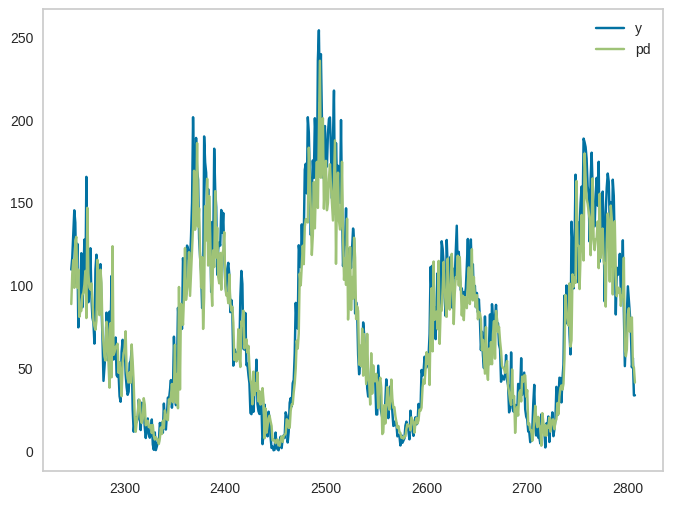

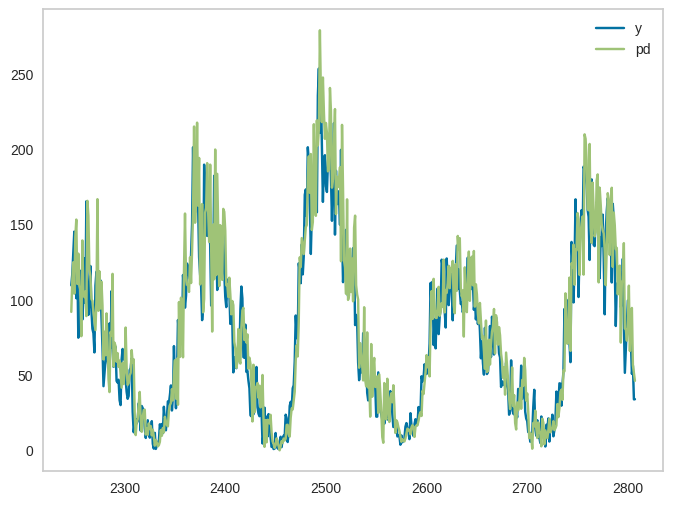

In [251]:
serial=0

for view in ViewsDataset:
  print('length of the views:',len(view))
  df_new = pd.DataFrame(view)
  df_new.columns = ['y']
  y_train_en, y_val_en, y_test_in_na, x_train_en, x_val_en, x_test_en_na, test_en_na, scale_en, en_df, val_en_na, train_en_na =DataTrainTestVal(df)
  #y_train_en, y_val_en, y_test_in_na, x_train_en, x_val_en, x_test_en_na=DataTrainTestVal(df_new)

  y_train=np.concatenate((y_train_en, y_val_en), axis=0)
  x_train=np.concatenate((x_train_en, x_val_en), axis=0)

  Train_combined = pd.concat([train_en, val_en], ignore_index=True)
  
  y_val=y_test_in_na
  x_val=x_test_en_na

  #Val_df=

  #models=[]
  #model_LSTM, model_GRU, model_CNN, model_RNN, model_BiLSTM =create_model(x_train, units=32)
  #models.append(model_BiLSTM)
  #models.append(model_LSTM)
  #models.append(model_GRU)
  #models.append(model_CNN)
  #models.append(model_RNN)
  Test_Predictions=pd.DataFrame()
  Train_Predictions=pd.DataFrame()
  
  #print('Data views number ===>',serial,'<========')
  serial=serial+1 
  
  #view_accuracy.append(Model_Execution(models,x_train, y_train, x_val, y_val,x_test_en, y_test_in, batch_size=64))
  # test_en_na has been utilized for validation purpose of specific view
  view_accuracy_i,Test_Predictions_i,ytest_original=Model_Execution(models,x_train, y_train, x_val, y_val, x_test_en, y_test_in, test_en, scale_en, en_df, test_en_na, Train_combined, batch_size=64)

  view_accuracy.append(view_accuracy_i)
  print('shape of predictions:',np.array(Test_Predictions_i).shape)
  view_predictions.append(Test_Predictions_i)
view_predictions.append(ytest_original.tolist())
#y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en=DataTrainTestVal(df)


In [ ]:
prediction_array=np.array(view_predictions[0][:][:])
for i in range(1,view_max+1):
  prediction_array=np.concatenate((prediction_array, np.array(view_predictions[i][:][:])), axis = 1)

#Multi-view ensemble of the predictions
MVL_pred=np.mean(prediction_array[:,1:], axis=1)

performance=Measures(np.transpose(prediction_array[0]).tolist(),np.transpose(MVL_pred).tolist())

print("RMSE:",performance[0])
print("MAPE:",performance[1])

In [289]:
MVL_pred.tolist()

[90.0587043762207,
 109.72497940063477,
 119.91162109375,
 101.01022338867188,
 134.24691009521484,
 141.0934829711914,
 104.32364273071289,
 119.85530853271484,
 94.92959213256836,
 95.38908386230469,
 79.93600463867188,
 116.4699478149414,
 99.88510131835938,
 100.71915435791016,
 106.8412971496582,
 84.41304016113281,
 156.09881591796875,
 131.39710998535156,
 109.12825012207031,
 106.37492370605469,
 100.53754425048828,
 94.93255233764648,
 85.1771125793457,
 80.42287063598633,
 76.20875930786133,
 89.03232955932617,
 140.95609283447266,
 91.35552215576172,
 100.20182800292969,
 101.51338958740234,
 106.54722213745117,
 84.32677459716797,
 62.15320587158203,
 67.59074974060059,
 58.53271293640137,
 84.19441223144531,
 72.2252311706543,
 49.618019104003906,
 38.07635498046875,
 77.5718994140625,
 59.955421447753906,
 120.17309188842773,
 56.548423767089844,
 65.25983047485352,
 65.5888557434082,
 60.952449798583984,
 64.33386993408203,
 50.93502235412598,
 56.252986907958984,
 47.43

In [277]:
view_accuracy

[21.625145922430665, [22.575028123564373], [24.382478179997687]]

In [275]:
prediction_array=np.array(view_predictions[0][:][:])
for i in range(1,view_max+1):
  print(i)
  prediction_array=np.concatenate((prediction_array, np.array(view_predictions[i][:][:])), axis = 1)


prediction_array.shape


1
2


(561, 3)

In [283]:
MVL_pred=np.mean(prediction_array[:,1:], axis=1)
MVL_pred.shape

(561,)

In [276]:
pd.DataFrame(prediction_array)
np.mean(a, axis=0)

,0,1,2
0,87.000122,88.494980,91.622429
1,97.045273,106.911079,112.538879
2,105.816513,115.124298,124.698944
3,109.206718,98.303520,103.716927
4,120.532150,126.807175,141.686646
...,...,...,...
556,72.803719,73.887276,90.701782
557,78.609009,80.418564,94.218964
558,58.714272,51.159809,56.091614
559,56.328251,50.179760,50.877987
